# Sample APP $-$ TRAINING 

**Objective**

 - extract FTS transfer error
 - tokenization
 - word2vec (Language Model)
 - K-Means (Clustering)
   - optimisation of K
   - training of best K 

### Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("sample_app").getOrCreate()
spark

CPU times: user 53 ms, sys: 35.3 ms, total: 88.2 ms
Wall time: 7.64 s


## Import data

**Read from HDFS**

In [2]:
# %%time 

# import pyspark.sql.functions as F
# # 18th October 2019
# day = "2019/10/18"

# # FTS data path
# path_list = ['/project/monitoring/archive/fts/raw/complete/{}/*'.format(day)]
# # path_list = "/project/monitoring/archive/fts/raw/complete/2019/10/18/*"

# # load the data in the json file
# all_transfers = spark.read.json(path_list)

# # retrieve just data
# all_transfers = all_transfers.select("data.*")

# # filter errors only
# errors = all_transfers.filter(all_transfers["t_final_transfer_state_flag"] == 0)

# # sample 100 random rows
# n = errors.count()
# errors = errors.sample(withReplacement=False, fraction=1.*100/n).limit(100)

# # add row id and select only relevant variables
# errors = errors.withColumn("msg_id", F.monotonically_increasing_id()).select(
#     "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# # show top 10 rows
# errors.toPandas().head(10)

**Save extracted data as json file**

In [3]:
# errors.coalesce(1).write.format('json').mode('overwrite').save('fts_18oct19.json')


**Alternative: read from csv file**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

errors = spark.read.json("fts_18oct19.json").select(
    "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# visualize data
errors.toPandas().head(10)

,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,TRANSFER globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure 530-globus_gsi_gssapi: Error with GSI credential 530-globus_gsi_gssapi: Error with gss credential handle 530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem 530- with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk 530- has expired 82 minutes ago. 530- 530 End.,dcsrm.usatlas.bnl.gov,lcgdpmse.dnp.fmph.uniba.sk,0
1,1,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root; Disk quota exceeded,transfer.ultralight.org,cmseos-gridftp.fnal.gov,0
2,2,TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match 7f2e5a09 != dd4c5a09,srm.grid.sara.nl,storm-01.roma3.infn.it,1571369818367
3,3,Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied,xrootd.aglt2.org,xrootd.grid.sara.nl,1571356856659
4,4,"TRANSFER ERROR: Copy failed with mode streamed, with error: Authentication error, reached maximum number of attempts",head01.aglt2.org,webdav.grid.surfsara.nl,1571358842799
5,5,TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match fc03cf41 != 86adcf41,grid002.ft.uam.es,storm-01.roma3.infn.it,1571358982792
6,6,Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied,atlasxrootd-kit.gridka.de,sdrm.t1.grid.kiae.ru,1571413532970
7,7,DESTINATION SRM_PUTDONE Error on the surl srm://srm-cms.gridpp.rl.ac.uk/castor/ads.rl.ac.uk/prod/cms/store/test/rucio/cms//store/mc/RunIIFall17NanoAODv5/RSGravitonToGammaGamma_kMpl02_M_750_TuneCP2_13TeV_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano1June2019_102X_mc2017_realistic_v7-v1/40000/73D01910-76FA-624B-B90B-98F3156BBEE3.root while putdone : [SE][PutDone][SRM_INVALID_PATH] This SURL does not exist in the original request,node12.datagrid.cea.fr,srm-cms.gridpp.rl.ac.uk,1571403898053
8,8,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,tbn18.nikhef.nl,tech-se.hep.technion.ac.il,0
9,9,Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Unable to create /atlas/atlasscratchdisk/rucio/tests/66/8a/file1_b7ace96a-9f39-4ae0-80c0-c0b58d68622f; permission denied,xrootd-at1-door.pic.es,xrootd.lcg.triumf.ca,1571400876642


## Tokenization

In [3]:
from language_models import tokenizer
err_tks = tokenizer(errors, err_col="t__error_message", id_col="msg_id")

# visualize tokenization
err_tks.toPandas().head(4)

,msg_id,t__error_message,corrected_message,tokens,tokens_cleaned,stop_token,stop_token_1
0,0,TRANSFER globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure 530-globus_gsi_gssapi: Error with GSI credential 530-globus_gsi_gssapi: Error with gss credential handle 530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem 530- with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk 530- has expired 82 minutes ago. 530- 530 End.,TRANSFER globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure 530-globus_gsi_gssapi: Error with GSI credential 530-globus_gsi_gssapi: Error with gss credential handle 530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem 530- with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk 530- has expired 82 minutes ago. 530- 530 End.,"[transfer, globus_ftp_client:, the, server, responded, with, an, error, 530, 530-globus_xio:, server, side, credential, failure, 530-globus_gsi_gssapi:, error, with, gsi, credential, 530-globus_gsi_gssapi:, error, with, gss, credential, handle, 530-globus_credential:, error, with, credential:, the, host, credential:, /etc/grid-security/dpmmgr/dpmcert.pem, 530-, with, subject:, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530-, has, expired, 82, minutes, ago., 530-, 530, end.]","[transfer, globus_ftp_client, the, server, responded, with, an, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, with, gsi, credential, 530, globus_gsi_gssapi, error, with, gss, credential, handle, 530, globus_credential, error, with, credential, the, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, with, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, has, expired, 82, minutes, ago, 530, 530, end]","[transfer, globus_ftp_client, server, responded, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, gsi, credential, 530, globus_gsi_gssapi, error, gss, credential, handle, 530, globus_credential, error, credential, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, expired, 82, minutes, ago, 530, 530, end]","[transfer, globus_ftp_client, server, responded, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, gsi, credential, 530, globus_gsi_gssapi, error, gss, credential, handle, 530, globus_credential, error, credential, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, expired, 82, minutes, ago, 530, 530, end]"
1,1,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root; Disk quota exceeded,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root Disk quota exceeded,"[transfer, globus_ftp_client:, the, server, responded, with, an, error, 500, command, failed., :, open/create, :, [error], server, responded, with, an, error:, [3021], unable, to, get, quota, space, -, quota, not, defined, or, exhausted, /eos/uscms/store/user/skumar/jyoti/jetht_2017/data_c/jetht/crab_era_data_c/191016_062739/0001/ggtree_data_1972.root, disk, quota, exceeded]","[transfer, globus_ftp_client, the, server, responded, with, an, error, 500, command, f

## Language Model: Word2Vec

### Training

In [7]:
from language_models import train_w2v, load_w2v

# train word2vec
# w2v_model = train_w2v(err_tks, tks_col="stop_token_1", id_col="msg_id", out_col='message_vector',
#                     vec_size=3, min_count=1, save_path=None)

# save the trained model
# w2v_model.write().overwrite().save("w2v_model")

# load saved model
w2v_model = load_w2v("w2v_model")

### Inference 

In [8]:
# get the vector representation of messages
err_tks = w2v_model.transform(err_tks)

# visualize language model
err_tks.toPandas().head(4)

,msg_id,t__error_message,corrected_message,tokens,tokens_cleaned,stop_token,stop_token_1,message_vector
0,0,TRANSFER globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure 530-globus_gsi_gssapi: Error with GSI credential 530-globus_gsi_gssapi: Error with gss credential handle 530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem 530- with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk 530- has expired 82 minutes ago. 530- 530 End.,TRANSFER globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure 530-globus_gsi_gssapi: Error with GSI credential 530-globus_gsi_gssapi: Error with gss credential handle 530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem 530- with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk 530- has expired 82 minutes ago. 530- 530 End.,"[transfer, globus_ftp_client:, the, server, responded, with, an, error, 530, 530-globus_xio:, server, side, credential, failure, 530-globus_gsi_gssapi:, error, with, gsi, credential, 530-globus_gsi_gssapi:, error, with, gss, credential, handle, 530-globus_credential:, error, with, credential:, the, host, credential:, /etc/grid-security/dpmmgr/dpmcert.pem, 530-, with, subject:, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530-, has, expired, 82, minutes, ago., 530-, 530, end.]","[transfer, globus_ftp_client, the, server, responded, with, an, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, with, gsi, credential, 530, globus_gsi_gssapi, error, with, gss, credential, handle, 530, globus_credential, error, with, credential, the, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, with, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, has, expired, 82, minutes, ago, 530, 530, end]","[transfer, globus_ftp_client, server, responded, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, gsi, credential, 530, globus_gsi_gssapi, error, gss, credential, handle, 530, globus_credential, error, credential, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, expired, 82, minutes, ago, 530, 530, end]","[transfer, globus_ftp_client, server, responded, error, 530, 530, globus_xio, server, side, credential, failure, 530, globus_gsi_gssapi, error, gsi, credential, 530, globus_gsi_gssapi, error, gss, credential, handle, 530, globus_credential, error, credential, host, credential, /etc/grid-security/dpmmgr/dpmcert.pem, 530, subject, /c=sk/o=slovakgrid/o=fmphi/cn=lcgdpmse.dnp.fmph.uniba.sk, 530, expired, 82, minutes, ago, 530, 530, end]","[-0.07999775649570838, -0.14800774151595628, -0.025657285459157898]"
1,1,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root; Disk quota exceeded,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root Disk quota exceeded,"[transfer, globus_ftp_client:, the, server, responded, with, an, error, 500, command, failed., :, open/create, :, [error], server, responded, with, an, error:, [3021], unable, to, get, quota, space, -, quota, not, defined, or, exhausted, /eos/uscms/store/user/skumar/jyoti/jetht_2017/data_c/jetht/crab_era_data_c/191016_062739/0001/ggtree_data_1972.root, disk, quota, exceeded]","[

## K-Means

### Optimisation of K

In [10]:
%%time 

import kmeans
import importlib
importlib.reload(kmeans)

#from kmeans import K_optim

# initialize a grid of K (number of clusters) values
k_list = range(2, 10)

# train for different Ks
res = kmeans.K_optim(k_list, dataset=err_tks, tks_vec="message_vector", ft_col="features",
              distance="cosine", initSteps=50, tol=0.0001, maxIter=30)

Started at: 2020-03-10 09:55:17

With K=2
Within Cluster Sum of Squared Errors = 12.3793
Silhouette with cosine distance = 0.8402

Time elapsed: 0 minutes and 9 seconds.
------------------------------------------------------------
Started at: 2020-03-10 09:55:27

With K=3
Within Cluster Sum of Squared Errors = 7.6516
Silhouette with cosine distance = 0.7315

Time elapsed: 0 minutes and 4 seconds.
------------------------------------------------------------
Started at: 2020-03-10 09:55:31

With K=4
Within Cluster Sum of Squared Errors = 6.2754
Silhouette with cosine distance = 0.6444

Time elapsed: 0 minutes and 3 seconds.
------------------------------------------------------------
Started at: 2020-03-10 09:55:35

With K=5
Within Cluster Sum of Squared Errors = 3.3929
Silhouette with cosine distance = 0.6249

Time elapsed: 0 minutes and 3 seconds.
------------------------------------------------------------
Started at: 2020-03-10 09:55:39

With K=6
Within Cluster Sum of Squared Errors 

The best K according to the WSSE is 8
The best K according to the SILHOUETTE is 2


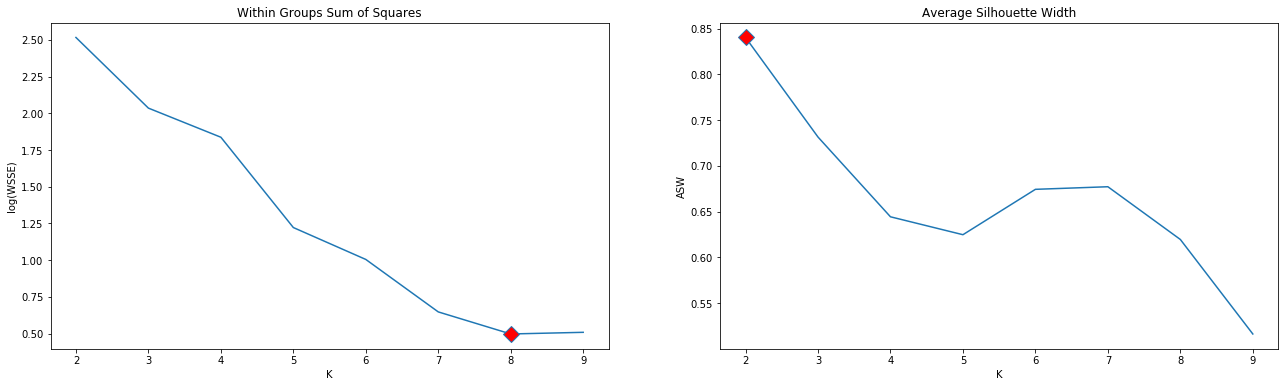

In [12]:
from kmeans import get_k_best, plot_metrics

# extract the best K according to within-cluster sum of squared distances (WSSE)
k_wsse = get_k_best(res, "wsse")
# extract the best K according to average silhouette value (ASW)
k_sil = get_k_best(res, "silhouette")

print("The best K according to the WSSE is {}".format(k_wsse))
print("The best K according to the SILHOUETTE is {}".format(k_sil))

# plot WSSE and ASW trends as a function of K (WARNING: you have to run two times the cell to get the plot)
plot_metrics(res)

### Re-training with best K

In [13]:
import time
import datetime
from kmeans import train_kmeans, kmeans_preproc
from pyspark.ml.evaluation import ClusteringEvaluator

distance = "cosine"
evaluator = ClusteringEvaluator(distanceMeasure=distance)
    
dataset = kmeans_preproc(err_tks.select("msg_id", "t__error_message", "tokens_cleaned", 
                                         "stop_token_1", "message_vector"), tks_vec="message_vector")

start_time = time.time()
start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print("Started at: {}\n".format(start_time_string))

best_model = train_kmeans(dataset, ft_col="features", k=k_sil, distance=distance,
                          initSteps=200, tol=0.0000001, maxIter=100,
                          save_path=None)
#                           save_path="best_K_model", mode="overwrite")

# compute metrics   
best_wsse = best_model.summary.trainingCost
best_silhouette = evaluator.evaluate(best_model.summary.predictions)

print("With K={}".format(k_sil))
print("Within Cluster Sum of Squared Errors = " + str(round(best_wsse,4)))
print("Silhouette with cosine distance = " + str(round(best_silhouette,4)))

print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), int((time.time() - start_time)%60)))
print('--'*30)

Started at: 2020-03-10 10:00:16

With K=2
Within Cluster Sum of Squared Errors = 12.3793
Silhouette with cosine distance = 0.8402

Time elapsed: 0 minutes and 12 seconds.
------------------------------------------------------------


### Visualisation

#### Word Cloud tokens

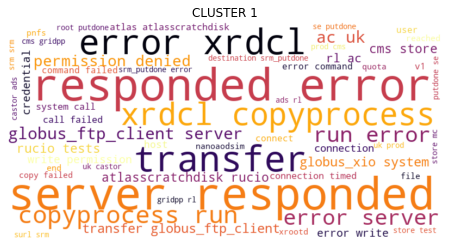

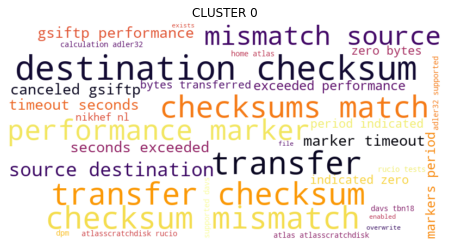

In [33]:
# from cluster_visualization import tokens_cloud
import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

#
cluster_visualization.tokens_cloud(best_model.summary.predictions, clust_col="prediction",
                                   msg_col="tokens_cleaned", save_path=None, figsize=(8,4),
                                   width=800, height=400, bkg_col="white", min_font_size=11)


#### Word Cloud message

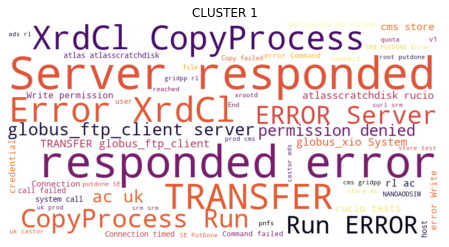

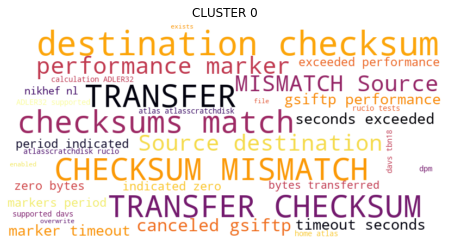

In [34]:
cluster_visualization.tokens_cloud(best_model.summary.predictions, clust_col="prediction",
                                   msg_col="t__error_message", save_path=None, figsize=(8,4),
                                   width=800, height=400, bkg_col="white", min_font_size=11)

#### Summary

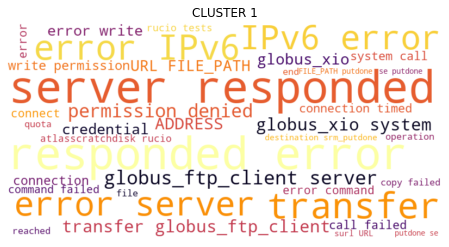

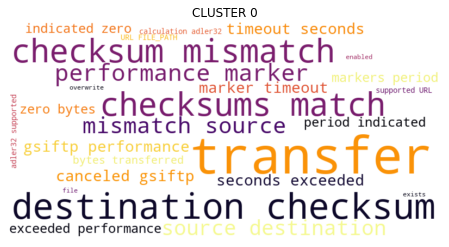

,n_messages,unique_strings,unique_patterns,top_3
prediction,,,,
1,72,54,42,"[{'msg': 'error on \$IPv6 [error] server responded with an error [3010] write permission denied', 'n': 9}, {'msg': 'destination srm_putdone error on the surl \$URL \$FILE_PATH while putdone [se][putdone][srm_invalid_path] this surl does not exist in the original request', 'n': 6}, {'msg': 'protocol not supported or path/url invalid \$URL \$FILE_PATH', 'n': 5}]"
0,28,21,19,"[{'msg': 'transfer transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded or all performance markers during that period indicated zero bytes transferred', 'n': 7}, {'msg': 'destination checksum checksum calculation for adler32 not supported for \$URL \$FILE_PATH', 'n': 3}, {'msg': 'destination file exists and overwrite is not enabled', 'n': 2}]"


In [38]:
import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

abs_dataset, summary = cluster_visualization.summary(best_model.summary.predictions,
                                        clust_col="prediction", tks_col="stop_token_1",
                                        abs_tks_out="abstract_tokens", abs_tks_in="tokens_cleaned",
                                        abstract=True, n_mess=3, wrdcld=True,
                                        original=None, n_src=3, n_dst=3)

summary

#### Summary Enriched - WORK IN PROGRESS

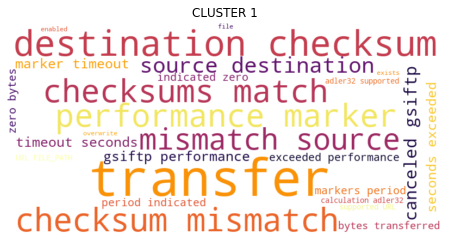

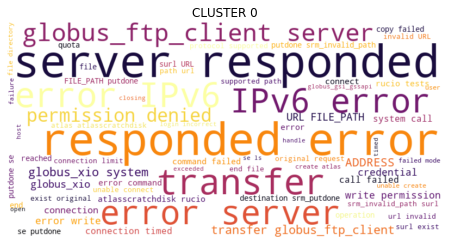

In [207]:
import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

g, gs, gd = cluster_visualization.summary(best_model.summary.predictions,
                                        clust_col="prediction", tks_col="stop_token_1",
                                        abs_tks_out="abstract_tokens", abs_tks_in="tokens_cleaned",
                                        abstract=True, n_mess=3, wrdcld=True,
                                        original=errors, n_src=3, n_dst=3, data_id="msg_id", 
                                        orig_id="msg_id", src_col="src_hostname", dst_col="dst_hostname")

In [208]:
g.toPandas().head()

,prediction,abstract_tokens,unique_patterns,rank_pattern
0,1,"[transfer, transfer, canceled, because, the, gsiftp, performance, marker, timeout, of, 360, seconds, has, been, exceeded, or, all, performance, markers, during, that, period, indicated, zero, bytes, transferred]",7,1
1,1,"[destination, checksum, checksum, calculation, for, adler32, not, supported, for, \$URL, \$FILE_PATH]",3,2
2,1,"[destination, file, exists, and, overwrite, is, not, enabled]",2,3
3,0,"[error, on, \$IPv6, [error], server, responded, with, an, error, [3010], write, permission, denied]",9,1
4,0,"[destination, srm_putdone, error, on, the, surl, \$URL, \$FILE_PATH, while, putdone, , [se][putdone][srm_invalid_path], this, surl, does, not, exist, in, the, original, request]",6,2


In [211]:
gs.toPandas().head()

,prediction,abstract_tokens,src_hostname,src_sites,rank_src
0,1,"[destination, checksum, checksum, calculation, for, adler32, not, supported, for, \$URL, \$FILE_PATH]",head01.aglt2.org,2,1
1,1,"[transfer, transfer, canceled, because, the, gsiftp, performance, marker, timeout, of, 360, seconds, has, been, exceeded, or, all, performance, markers, during, that, period, indicated, zero, bytes, transferred]",srm.triumf.ca,2,2
2,1,"[destination, checksum, checksum, calculation, for, adler32, not, supported, for, \$URL, \$FILE_PATH]",webdav-at1.pic.es,1,3
3,0,"[error, on, \$IPv6, [error], server, responded, with, an, error, [3010], write, permission, denied]",agh3.atlas.unimelb.edu.au,2,1
4,0,"[failed, to, stat, file, (no, such, file, or, directory)]",griddev03.slac.stanford.edu,2,2


In [212]:
gd.toPandas().head()

,prediction,abstract_tokens,dst_hostname,dst_sites,rank_dst
0,1,"[destination, checksum, checksum, calculation, for, adler32, not, supported, for, \$URL, \$FILE_PATH]",tbn18.nikhef.nl,3,1
1,1,"[transfer, transfer, canceled, because, the, gsiftp, performance, marker, timeout, of, 360, seconds, has, been, exceeded, or, all, performance, markers, during, that, period, indicated, zero, bytes, transferred]",dcache-se-atlas.desy.de,3,2
2,1,"[destination, file, exists, and, overwrite, is, not, enabled]",ganymede.hep.kbfi.ee,1,3
3,0,"[destination, srm_putdone, error, on, the, surl, \$URL, \$FILE_PATH, while, putdone, , [se][putdone][srm_invalid_path], this, surl, does, not, exist, in, the, original, request]",srm-cms.gridpp.rl.ac.uk,6,1
4,0,"[error, on, \$IPv6, [error], server, responded, with, an, error, [3010], write, permission, denied]",xrootd.grid.sara.nl,3,2


In [213]:
spark.sparkContext

<SparkContext master=local[*] appName=sample_app>

In [254]:
from abstraction_utils import abstract_params

dataset = abstract_params(best_model.summary.predictions, 
                          tks_col="tokens_cleaned", out_col="abstract_tokens")
        
errors.registerTempTable("sql_errors")
dataset.registerTempTable("sql_pred")

protocols1 = spark.sql("""
                           SELECT first(msg_id) as msg_id, prediction, abstract_tokens, 
                           count(abstract_tokens) as freq_msg
                           FROM sql_pred
                           GROUP BY prediction, abstract_tokens
                           ORDER BY prediction, freq_msg DESC
                           """)

protocols1.registerTempTable("prot")

protocols1 = spark.sql("""
                           SELECT first(msg_id) as msg_id, prediction, abstract_tokens as abstract_tokens,
                           freq_msg as freq_msg,
                           count(prediction) as rank
                           FROM prot
                           GROUP BY prediction
                           ORDER BY prediction, freq_msg DESC, abstract_tokens
                           """)

protocols2 = spark.sql("""
                           SELECT t__error_message, src_hostname,  
                           count(t__error_message) as freq_msg,
                           count(t__error_message, src_hostname) as freq_msg_src
                           FROM sql_errors
                           GROUP BY t__error_message, src_hostname 
                           ORDER BY freq_msg DESC, src_hostname
                           """)

protocols3 = spark.sql("""
                           SELECT t__error_message, dst_hostname, 
                           count(t__error_message) as freq_msg,
                           count(t__error_message, dst_hostname) as freq_msg_dst
                           FROM sql_errors
                           GROUP BY t__error_message, dst_hostname
                           ORDER BY freq_msg DESC, dst_hostname
                           """)

AnalysisException: "expression 'prot.`abstract_tokens`' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() (or first_value) if you don't care which value you get.;;\nSort [prediction#705 ASC NULLS FIRST, freq_msg#7168L DESC NULLS LAST, abstract_tokens#7167 ASC NULLS FIRST], true\n+- Aggregate [prediction#705], [first(msg_id#7156L, false) AS msg_id#7166L, prediction#705, abstract_tokens#7146 AS abstract_tokens#7167, freq_msg#7157L AS freq_msg#7168L, count(prediction#705) AS rank#7169L]\n   +- SubqueryAlias `prot`\n      +- Sort [prediction#705 ASC NULLS FIRST, freq_msg#7157L DESC NULLS LAST], true\n         +- Aggregate [prediction#705, abstract_tokens#7146], [first(msg_id#7L, false) AS msg_id#7156L, prediction#705, abstract_tokens#7146, count(abstract_tokens#7146) AS freq_msg#7157L]\n            +- SubqueryAlias `sql_pred`\n               +- Project [msg_id#7L, t__error_message#9, tokens_cleaned#39, stop_token_1#52, message_vector#77, features#682, prediction#705, abstract_message(tokens_cleaned#39) AS abstract_tokens#7146]\n                  +- Project [msg_id#7L, t__error_message#9, tokens_cleaned#39, stop_token_1#52, message_vector#77, features#682, UDF(features#682) AS prediction#705]\n                     +- Project [msg_id#7L, t__error_message#9, tokens_cleaned#39, stop_token_1#52, message_vector#77, UDF(named_struct(message_vector, message_vector#77)) AS features#682]\n                        +- Project [msg_id#7L, t__error_message#9, tokens_cleaned#39, stop_token_1#52, message_vector#77]\n                           +- Project [msg_id#7L, t__error_message#9, corrected_message#29, tokens#33, tokens_cleaned#39, stop_token#45, stop_token_1#52, UDF(stop_token_1#52) AS message_vector#77]\n                              +- Project [msg_id#7L, t__error_message#9, corrected_message#29, tokens#33, tokens_cleaned#39, stop_token#45, UDF(stop_token#45) AS stop_token_1#52]\n                                 +- Project [msg_id#7L, t__error_message#9, corrected_message#29, tokens#33, tokens_cleaned#39, UDF(tokens_cleaned#39) AS stop_token#45]\n                                    +- Project [msg_id#7L, t__error_message#9, corrected_message#29, tokens#33, <lambda>(tokens#33) AS tokens_cleaned#39]\n                                       +- Project [msg_id#7L, t__error_message#9, corrected_message#29, UDF(corrected_message#29) AS tokens#33]\n                                          +- Project [msg_id#7L, t__error_message#9, split_urls(t__error_message#9) AS corrected_message#29]\n                                             +- Project [msg_id#7L, t__error_message#9]\n                                                +- Project [msg_id#7L, t__error_message#9, src_hostname#8, dst_hostname#6, timestamp_tr_comp#10L]\n                                                   +- Relation[dst_hostname#6,msg_id#7L,src_hostname#8,t__error_message#9,timestamp_tr_comp#10L] json\n"

In [252]:
protocols1.show()

+------+----------+--------------------+--------+----+
|msg_id|prediction|     abstract_tokens|freq_msg|rank|
+------+----------+--------------------+--------+----+
|     3|         0|[error, on, \$IPv...|       9|  42|
|    11|         1|[transfer, transf...|       7|  19|
+------+----------+--------------------+--------+----+



In [228]:
protocols2.show()

+--------------------+--------------------+--------+------------+
|    t__error_message|        src_hostname|freq_msg|freq_msg_src|
+--------------------+--------------------+--------+------------+
|Error on XrdCl::C...|agh3.atlas.unimel...|       2|           2|
|TRANSFER  globus_...|   eoscmsftp.cern.ch|       2|           2|
|Failed to stat fi...|griddev03.slac.st...|       2|           2|
|TRANSFER  Transfe...|       srm.triumf.ca|       2|           2|
|TRANSFER CHECKSUM...|atlas-gridftp.bu.edu|       1|           1|
|TRANSFER  globus_...| atlasse.lnf.infn.it|       1|           1|
|Protocol not supp...|atlasxrootd-kit.g...|       1|           1|
|Protocol not supp...|atlasxrootd-kit.g...|       1|           1|
|Error on XrdCl::C...|atlasxrootd-kit.g...|       1|           1|
|Error on XrdCl::C...|basilisk02.westgr...|       1|           1|
|TRANSFER  Transfe...|bohr3226.tier2.he...|       1|           1|
|TRANSFER  globus_...|bohr3226.tier2.he...|       1|           1|
|Error on 

#### Scatterplot 

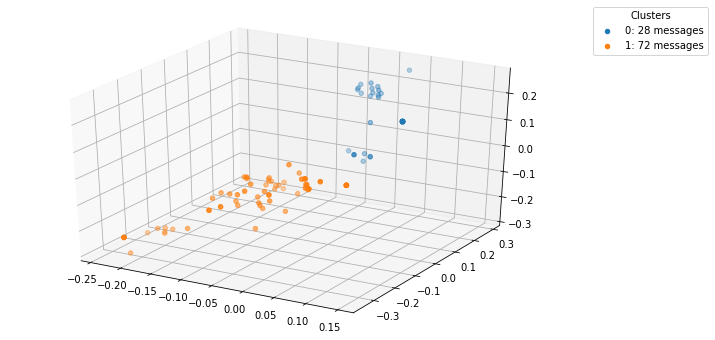

In [39]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np

data = best_model.summary.predictions.select("t__error_message", "features", "prediction").toPandas()

df = pd.DataFrame(None, columns=["cluster", "x", "y", "z"])
i=1

for clust_id in range(0, best_model.summary.k):
    cluster = data["features"][data.prediction == clust_id]
    for row in cluster:
        x, y, z  = row
        df.loc[i] = [clust_id, x, y, z]
        i += 1 

# Create plot
fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
for clust_id in range(0, best_model.summary.k):
    cluster_df = df[df.cluster == clust_id]
    _ = ax.scatter(cluster_df.x, cluster_df.y, cluster_df.z, label="{}: {} messages".format(clust_id, cluster_df.shape[0]) )
_ = ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### Messages 

In [21]:
from termcolor import colored

for clust_id in range(0, best_model.summary.k):
    cluster = data["t__error_message"][data.prediction == clust_id]
    print(colored("Cluster n.{}".format(clust_id), 'red'), "\n")
    for idx, row in enumerate(cluster.head(10)):
        print("{}.".format(idx), row, "\n\n")

Cluster n.0 

0. TRANSFER  globus_ftp_client: the server responded with an error 530 530-globus_xio: Server side credential failure  530-globus_gsi_gssapi: Error with GSI credential  530-globus_gsi_gssapi: Error with gss credential handle  530-globus_credential: Error with credential: The host credential: /etc/grid-security/dpmmgr/dpmcert.pem  530-     with subject: /C=SK/O=SlovakGrid/O=FMPhI/CN=lcgdpmse.dnp.fmph.uniba.sk  530-     has expired 82 minutes ago.  530-  530 End.    


1. TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/uscms/store/user/skumar/jyoti/JetHT_2017/Data_C/JetHT/crab_Era_Data_C/191016_062739/0001/ggtree_data_1972.root; Disk quota exceeded     


2. Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied  


3. TRANSFER  ERROR: Copy failed with mode strea

### Inference 

In [2]:
# %%time 

# import pyspark.sql.functions as F
# # 19th October 2019
# day = "2020/03/05"

# # FTS data path
# path_list = ['/project/monitoring/archive/fts/raw/complete/{}/*'.format(day)]
# # path_list = "/project/monitoring/archive/fts/raw/complete/2019/10/18/*"

# # load the data in the json file
# all_transfers = spark.read.json(path_list)

# # retrieve just data
# all_transfers = all_transfers.select("data.*")

# # filter test_errors only
# test_errors = all_transfers.filter(all_transfers["t_final_transfer_state_flag"] == 0)

# # sample 100 random rows
# n = test_errors.count()
# test_errors = test_errors.sample(withReplacement=False, fraction=1.*100/n).limit(100)

# # add row id and select only relevant variables
# test_errors = test_errors.withColumn("msg_id", F.monotonically_increasing_id()).select(
#     "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# # show top 10 rows
# test_errors.toPandas().head(10)

CPU times: user 616 ms, sys: 154 ms, total: 770 ms
Wall time: 2min 9s


,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414544375
1,1,TRANSFER Transfer canceled because the gsiftp...,dcgftp.usatlas.bnl.gov,srm.ndgf.org,0
2,2,TRANSFER ERROR: Copy failed with mode 3rd pus...,golias100.farm.particle.cz,gfe02.grid.hep.ph.ic.ac.uk,1583427213286
3,3,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
4,4,TRANSFER ERROR: Copy failed with mode 3rd pul...,lapp-se01.in2p3.fr,lcg-lrz-http.grid.lrz.de,1583400047771
5,5,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
6,6,TRANSFER globus_ftp_client: the server respon...,sdrm.t1.grid.kiae.ru,torik1.ulakbim.gov.tr,0
7,7,TRANSFER globus_ftp_client: the server respon...,cmsio.rc.ufl.edu,cmseos-gridftp.fnal.gov,0
8,8,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414700237
9,9,globus_ftp_client: the server responded with a...,eosatlassftp.cern.ch,storm-01.roma3.infn.it,0


**Save extracted data as json file**

In [117]:
# test_errors.coalesce(1).write.format('json').mode('overwrite').save('fts_05mar20.json')


**Load data from json file**

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

test_errors = spark.read.json("fts_05mar20.json").select(
    "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# visualize data
test_errors.toPandas().head(10)

,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory.,srm-eospublic.cern.ch,srm-public.cern.ch,0
1,1,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",gftp.t2.ucsd.edu,dcache-se-cms.desy.de,0
2,2,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",heplnx204.pp.rl.ac.uk,storm-fe-cms.cr.cnaf.infn.it,0
3,3,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500",se01.grid.cyfronet.pl,se.hpc.utfsm.cl,1583439822407
4,4,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 404 : File not found",ccdavatlas.in2p3.fr,gftp01.ncg.ingrid.pt,1583423079983
5,5,DESTINATION OVERWRITE Result HTTP 502 : Unexpected server error: 502 after 1 attempts,f-dpm000.grid.sinica.edu.tw,eosatlashttp.cern.ch,0
6,6,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup.",lcg-se0.ifh.de,grid-dav.rzg.mpg.de,1583434383382
7,7,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : Error registering globus write error: Unknown error 2033,eosatlassftp.cern.ch,dcsrm.usatlas.bnl.gov,0
8,8,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode] HTTP/1.1 404 Not Found Detail: <!DOCTYPE HTML PUBLIC -//IETF//DTD HTML 2.0//EN> <html><head> <title>404 Not Found</title> </head><body> <h1>Not Found</h1> <p>The requested URL /gridsite-delegation was not found on this server.</p> </body></html> .",dav.ndgf.org,f-dpm000.grid.sinica.edu.tw,1583431419198
9,9,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",storm-fe.cr.cnaf.infn.it,head01.aglt2.org,0


#### Static predictions

In [6]:
# %%time
# import importlib
# import kmeans
# importlib.reload(kmeans)

# test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
#                     w2v_model_path="w2v_model", tks_vec="message_vector", ft_col="features",
#                     kmeans_mode="load", kmeans_model_path="best_K_model",
#                     pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
#                     distance="cosine", opt_initSteps=10, opt_tol=0.0001, opt_maxIter=30, #K_optim
#                     tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
#                     )

CPU times: user 234 ms, sys: 57.2 ms, total: 291 ms
Wall time: 4.95 s


#### Online re-training 

In [11]:
%%time

importlib.reload(kmeans)

test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
                    w2v_model_path="w2v_model", tks_vec="message_vector", ft_col="features",
                    kmeans_mode="train", kmeans_model_path=None,
                    pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
                    distance="cosine", opt_initSteps=10, opt_tol=0.0001, opt_maxIter=30, #K_optim
                    tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
                    )

Started at: 2020-03-10 16:24:54

With K=2
Within Cluster Sum of Squared Errors = 7.2657
Silhouette with cosine distance = 0.8761

Time elapsed: 0 minutes and 3 seconds.
------------------------------------------------------------
Started at: 2020-03-10 16:24:58

With K=3
Within Cluster Sum of Squared Errors = 5.307
Silhouette with cosine distance = 0.8495

Time elapsed: 0 minutes and 1 seconds.
------------------------------------------------------------
Started at: 2020-03-10 16:24:59

With K=4
Within Cluster Sum of Squared Errors = 3.9429
Silhouette with cosine distance = 0.5079

Time elapsed: 0 minutes and 1 seconds.
------------------------------------------------------------
Started at: 2020-03-10 16:25:01

With K=5
Within Cluster Sum of Squared Errors = 2.7164
Silhouette with cosine distance = 0.4875

Time elapsed: 0 minutes and 1 seconds.
------------------------------------------------------------
Started at: 2020-03-10 16:25:03

With K=6
Within Cluster Sum of Squared Errors = 

#### Visualization 

##### Summary 

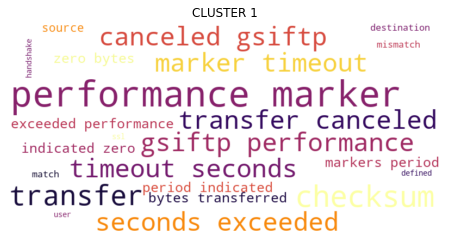

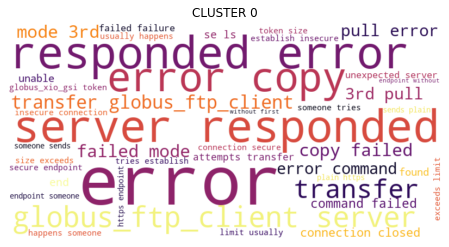

,n_messages,unique_strings,unique_patterns,top_3
prediction,,,,
0,79,52,41,"[{'msg': 'transfer globus_ftp_client the server responded with an error 500 500 command failed 500 globus_xio_gsi token size exceeds limit usually happens when someone tries to establish a insecure connection with a secure endpoint e.g when someone sends plain http to a https endpoint without first establishing a ssl session 500 end', 'n': 6}, {'msg': 'error reported from srm_ifce 2 [se][ls][srm_invalid_path] no such file or directory', 'n': 5}, {'msg': 'result (neon) could not read status line connection was closed by server after 1 attempts', 'n': 5}]"
1,12,6,6,"[{'msg': 'transfer transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded or all performance markers during that period indicated zero bytes transferred', 'n': 7}, {'msg': 'destination checksum (neon) ssl handshake failed connection timed out during ssl handshake', 'n': 1}, {'msg': 'destination file exists and overwrite is not enabled', 'n': 1}]"


In [12]:
import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

abs_dataset, summary = cluster_visualization.summary(test_predictions,
                                        clust_col="prediction", tks_col="stop_token_1",
                                        abs_tks_out="abstract_tokens", abs_tks_in="tokens_cleaned",
                                        abstract=True, n_mess=3, wrdcld=True,
                                        original=None, n_src=3, n_dst=3)

summary

##### Scatterplot 

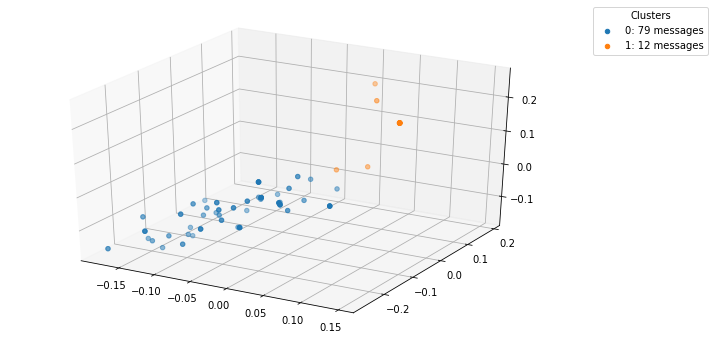

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np
from kmeans import get_k_best, plot_metrics

data = test_predictions.select("t__error_message", "features", "prediction").toPandas()
k = test_predictions.select("prediction").distinct().count()
df = pd.DataFrame(None, columns=["cluster", "x", "y", "z"])
i=1

for clust_id in range(0, k):
    cluster = data["features"][data.prediction == clust_id]
    for row in cluster:
        x, y, z  = row
        df.loc[i] = [clust_id, x, y, z]
        i += 1 

# Create plot
fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
for clust_id in range(0, k):
    cluster_df = df[df.cluster == clust_id]
    _ = ax.scatter(cluster_df.x, cluster_df.y, cluster_df.z, label="{}: {} messages".format(clust_id, cluster_df.shape[0]) )
_ = ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### Messages 

In [14]:
from termcolor import colored

for clust_id in range(0, k):
    cluster = data["t__error_message"][data.prediction == clust_id]
    print(colored("Cluster n.{}".format(clust_id), 'red'), "\n")
    for idx, row in enumerate(cluster.head(10)):
        print("{}.".format(idx), row, "\n\n")

Cluster n.0 

0. Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory. 


1. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500  


2. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 404 : File not found  


3. DESTINATION OVERWRITE   Result HTTP 502 : Unexpected server error: 502  after 1 attempts 


4. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup.  


5. TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : Error registering globus write error: Unknown error 2033    


6. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode]